# Identifying Fraudulent Activities from Take Home Challenge

The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
from datetime import timedelta

from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score

## Read and Pre-processing
Check file shape, null values, invalid values, merge data

In [2]:
fraud_data = pd.read_csv('Fraud_data.csv')
ip_to_country = pd.read_csv('IpAddress_to_Country.csv')

In [3]:
fraud_data.shape

(151112, 11)

In [4]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [22]:
fraud_data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [19]:
ip_to_country.shape

(138846, 3)

In [30]:
ip_to_country.describe()

,lower_bound_ip_address,upper_bound_ip_address
count,1.388460e+05,1.388460e+05
mean,2.724532e+09,2.724557e+09
std,8.975215e+08,8.974979e+08
min,1.677722e+07,1.677747e+07
25%,1.919930e+09,1.920008e+09
50%,3.230887e+09,3.230888e+09
75%,3.350465e+09,3.350466e+09
max,3.758096e+09,3.758096e+09


Populate the country info using IP address

In [3]:
def to_country(ip):
    ip_country = ip_to_country[(ip_to_country.lower_bound_ip_address <= ip) 
                              &(ip_to_country.upper_bound_ip_address >= ip)].country
    if ip_country.shape[0] == 1:
        return ip_country.iloc[0]
    else:
        return "N/A"

fraud_data["country"] = fraud_data.ip_address.apply(to_country)

In [4]:
fraud_data["country"].unique().size

182

Format the timestamp column to get the time_to_purchase (in hours) after sign up

In [6]:
signup = fraud_data.signup_time.apply(pd.to_datetime)
purchase = fraud_data.purchase_time.apply(pd.to_datetime)
fraud_data['time_to_purchase'] = (purchase - signup).apply(lambda x: x.seconds)/3600

## EDA

In [38]:
fraud_data.groupby('class').user_id.count()

class
0    136961
1     14151
Name: user_id, dtype: int64

In [5]:
positive_class_rate = 100*fraud_data[fraud_data['class'] == 1].shape[0]/len(fraud_data)
print('Positive class (fraud) records counts for %2.2f percent of the total records'% (positive_class_rate))

Positive class (fraud) records counts for 9.36 percent of the total records


### Gender
Check to see if gender is a key variable. 
Based on the chart below,  gendor doesn't look like a key factor in determining fraud.

Text(0,0.5,'Counts')

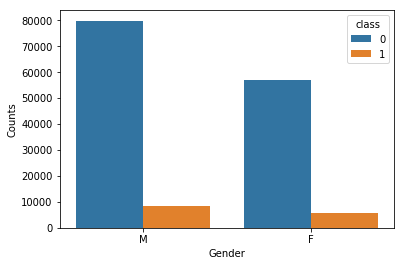

In [58]:
sns.countplot(x='sex', hue='class', data=fraud_data)
plt.xlabel("Gender")
plt.ylabel("Counts")

### Purchase_value

Text(0.425,0.5,'Purchase Value')

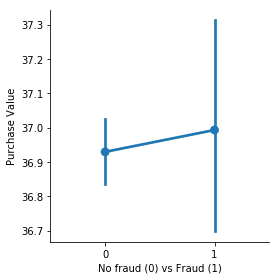

In [62]:
sns.factorplot(x="class", y="purchase_value", data=fraud_data)
plt.xlabel("No fraud (0) vs Fraud (1)")
plt.ylabel("Purchase Value")

There seems no difference in purchasing value between two classes.

### Age

Text(-5.825,0.5,'Age')

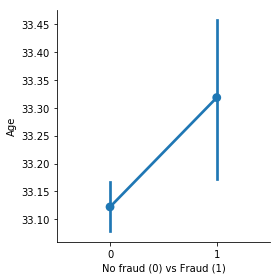

In [64]:
sns.factorplot(x="class", y="age", data=fraud_data)
plt.xlabel("No fraud (0) vs Fraud (1)")
plt.ylabel("Age")

Both classes have a mean age value around 33. It's not a significant difference either.

### Time_to_purchase

Text(9.925,0.5,'Sign-up to Purchase Time in hours')

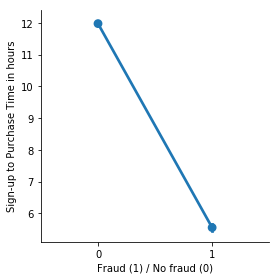

In [61]:
sns.factorplot(x="class", y="time_to_purchase", data=fraud_data)
plt.xlabel("No fraud (0) vs Fraud (1)")
plt.ylabel("Sign-up to Purchase Time in hours")

There seems to be a dramatic difference in time_to_purchase value between two classes.

### Uniqueness in device ID and IP address

In [16]:
print('Unique user count: ' + str(fraud_data.user_id.unique().size))
print('Unique device count: ' + str(fraud_data.device_id.unique().size))
print('Unique ipaddress count: ' + str(fraud_data.ip_address.unique().size))

Unique user count: 151112
Unique device count: 137956
Unique ipaddress count: 143512


Create new feature to indicate how many unique user IDs used the same device and IP address.

In [7]:
userid_per_device = fraud_data.groupby("device_id").user_id.count()
fraud_data["userids_per_deviceid"] = fraud_data.device_id.apply(lambda x: userid_per_device[x])

userid_per_IP = fraud_data.groupby("ip_address").user_id.count()
fraud_data["userids_per_IP"] = fraud_data.ip_address.apply(lambda x: userid_per_IP[x])

Text(16.3,0.5,'Unique user IDs per IP address')

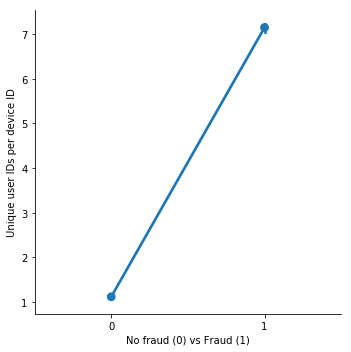

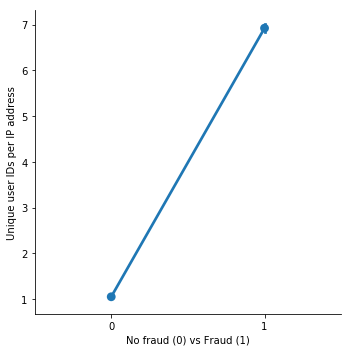

In [14]:
sns.catplot(x='class', y='userids_per_deviceid', data = fraud_data, kind='point')
plt.xlabel("No fraud (0) vs Fraud (1)")
plt.ylabel("Unique user IDs per device ID")

sns.catplot(x='class', y='userids_per_IP', data = fraud_data, kind='point')
plt.xlabel("No fraud (0) vs Fraud (1)")
plt.ylabel("Unique user IDs per IP address")

Draw a scatter plot to visualize the relationship between uniqueness of device ID and IP address.

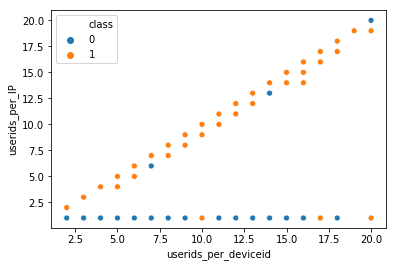

In [10]:
sns.scatterplot(x='userids_per_deviceid', y = 'userids_per_IP', 
                data = fraud_data[fraud_data['userids_per_deviceid']>1], hue='class')

## Prediction using Random Forest

In [16]:
# Create dummy columns for categorical features
source_dummies = pd.get_dummies(fraud_data.source, prefix='source')
browser_dummies = pd.get_dummies(fraud_data.browser, prefix='browser')
fraud_data = pd.concat([fraud_data, source_dummies, browser_dummies], axis =1)

In [17]:
fraud_data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'country', 'time_to_purchase', 'userids_per_deviceid', 'userids_per_IP',
       'source_Ads', 'source_Direct', 'source_SEO', 'browser_Chrome',
       'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari'],
      dtype='object')

The features that are included: Uniqueness of device ID and IP address, time to purchase, source, browser, purchase value, age.

In [25]:
fea = ['time_to_purchase', 'userids_per_deviceid','userids_per_IP', 'purchase_value', 'age', 'source_Ads', 'source_Direct', 'source_SEO', 'browser_Chrome',
       'browser_FireFox', 'browser_IE', 'browser_Opera', 'browser_Safari']
X = fraud_data[fea]
y = fraud_data['class']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [27]:
rf = RandomForestClassifier(class_weight = {0: .9, 1: .1})
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight={0: 0.9, 1: 0.1},
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [30]:
predictions = rf.predict(X_test)
roc_auc = roc_auc_score(y_test, predictions)

accuracy = rf.score(X_test, y_test)

In [45]:
print(classification_report(y_test, predictions))
print("Area under ROC curve: {:0.3f}".format(roc_auc))
print("Accuracy: %2.2f"%(accuracy))

             precision    recall  f1-score   support

          0       0.96      0.99      0.98     34286
          1       0.90      0.57      0.69      3492

avg / total       0.95      0.95      0.95     37778

Area under ROC curve: 0.779
Accuracy: 0.95


In [48]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature Ranking")
for f in range(X_train.shape[1]):
    print("{}. {}: {:1.2f}".format(f+1, X_train.columns[f], importances[indices[f]]))

Feature Ranking
1. time_to_purchase: 0.60
2. userids_per_deviceid: 0.15
3. userids_per_IP: 0.11
4. purchase_value: 0.08
5. age: 0.06
6. source_Ads: 0.00
7. source_Direct: 0.00
8. source_SEO: 0.00
9. browser_Chrome: 0.00
10. browser_FireFox: 0.00
11. browser_IE: 0.00
12. browser_Opera: 0.00
13. browser_Safari: 0.00


## Summary

1. The time difference between sign up and first order turns out to be the most important feature in detecting fraud. Fraud users tend to make purchases within 3 hours after signup, whereas normal users would wait for 12 hours on average.
2. The device ID associated to the purchase should be unique, otherwise this purchase is likely to be a fraud.
3. Purchase value, age, source and browser are less important in detecting fraud.
4. The currently model without any tunning has a precision of 0.9 and recall value as 0.57. We need to collect data around the cost of false positive (a normal user is classified as fraud and we may lose he/her) and false negative (a fraud was not detected) to determine how to evaluate the model.
